In [1]:
from IPython.display import Image
import cv2

In [2]:
import sagemaker

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

In [3]:
import os
import keras
import numpy as np
from keras.datasets import fashion_mnist

os.makedirs("./data")

Using TensorFlow backend.


FileExistsError: [Errno 17] File exists: './data'

In [225]:
import csv

test2 = []

file="./data/Plant Image Dataset - Sheet1.csv"
# file="./data/Plant Image Dataset - Tops.csv"
with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0:
            #print(f'{row[4]}')
            test2.append([row[3],float(row[4])])
            line_count+=1
        else:
            line_count+=1
test2 = np.array(test2)
print(test2.shape)

(128, 2)


In [226]:
# see how much we have of each category

catDict = {}

for entry in test2:
    if str(entry[1]) in catDict:
        catDict[str(entry[1])]+=1
    else: catDict[str(entry[1])] = 1
print(catDict)

{'7.5': 25, '7.0': 67, '6.5': 16, '8.0': 12, '6.0': 8}


In [227]:
import operator
# minCat = min(catDict.items(), key=operator.itemgetter(1))[1]
minCat = 20
print(minCat)

20


In [228]:
import csv

test2 = []
catDict = {}

file="./data/Plant Image Dataset - Sheet1.csv"
# file="./data/Plant Image Dataset - Tops.csv"
with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0:
            #print(f'{row[4]}')
            if row[10] in catDict:
                if catDict[row[4]] <= minCat:
                    catDict[row[4]]+=1
                    test2.append([row[3],float(row[4])])
                    line_count+=1
            else:
                catDict[row[4]] = 1
                test2.append([row[3],float(row[4])])
                line_count+=1
        else:
            line_count+=1
test2 = np.array(test2)
print(test2.shape)

(128, 2)


In [229]:
from sklearn.model_selection import train_test_split

path = "./data/Plant Images/"
size = len(test2)
test = np.empty((size, 64, 64, 3))
i = 0

for filename in os.listdir(path):
    im = cv2.imread(path+filename, cv2.IMREAD_COLOR)
    res = cv2.resize(im, (64, 64), interpolation=cv2.INTER_AREA)
    short_filename = filename[0:len(filename)-4]
    if len(np.where(test2==short_filename)[0]) > 0:
        test[np.where(test2==short_filename)[0][0]] = res
    
print(test.shape)
#x_train=test[0:23,:,:,:]
#x_val=test[24:47,:,:,:]

#y_train=test2[0:23]
#y_val=test2[24:47]

(x_train, x_val, y_train, y_val) = train_test_split(test, test2[:,1], test_size=0.75)

np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/validation', image=x_val, label=y_val)

(128, 64, 64, 3)


In [230]:
prefix = 'plant-health-doctor'

training_input_path   = sess.upload_data('data/training.npz', key_prefix=prefix+'/training')
validation_input_path = sess.upload_data('data/validation.npz', key_prefix=prefix+'/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-east-1-828447180034/plant-health-doctor/training/training.npz
s3://sagemaker-us-east-1-828447180034/plant-health-doctor/validation/validation.npz


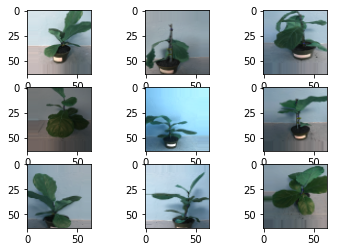

In [231]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

aug = ImageDataGenerator(horizontal_flip=True,
                             zoom_range=[0.9,1.1],
                             fill_mode="nearest",
                             brightness_range=[0.5,1.25],
                             width_shift_range=[-8,8],
                             height_shift_range=[-8,8])

it = aug.flow(x_train, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [240]:
 from sagemaker.tensorflow import TensorFlow
    
metric_definitions = [
    {
        'Name': 'train loss',
        'Regex': r'loss: (\S+)'
    },
    {
        'Name': 'valid loss',
        'Regex': r'val_loss: (\S+)'
    },
]

tf_estimator = TensorFlow(entry_point='mnist_keras_tf.py',
                          source_dir='my_src',
                          role=role,
                          train_instance_count=1,
                          train_instance_type='ml.m4.xlarge',
                          framework_version='1.12',
                          py_version='py3',
                          hyperparameters={'epochs': 10000, 'batch-size': 32},
                          metric_definitions=metric_definitions,
                          model_dir='s3://sagemaker-us-east-1-828447180034/adam-epoch=100-bs=4-lr=1e-2-decay=1e-5/model'
                         )

In [241]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

2019-12-04 19:03:49 Starting - Starting the training job...
2019-12-04 19:03:51 Starting - Launching requested ML instances.........
2019-12-04 19:05:24 Starting - Preparing the instances for training......
2019-12-04 19:06:49 Downloading - Downloading input data
2019-12-04 19:06:49 Training - Downloading the training image...
2019-12-04 19:07:09 Training - Training image download completed. Training in progress.2019-12-04 19:07:12,107 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-12-04 19:07:12,113 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 19:07:12,420 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install -U . -r requirements.txt
Processing /opt/ml/code
  Running setup.py bdist_wheel for sagemaker-keras-example: started
  Running setup.py bdist_wheel for sagemaker-keras-example: finished with status 'done'
  Stored in directory: /tmp/pip-ep

Using TensorFlow backend.
channels_last
x_train shape: (32, 64, 64, 3)
32 train samples
96 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
______________________________________

 - 0s - loss: 7.3624 - val_loss: 7.1520
Epoch 72/10000
 - 0s - loss: 7.5429 - val_loss: 7.1239
Epoch 73/10000
 - 0s - loss: 7.5865 - val_loss: 7.1148
Epoch 74/10000
 - 0s - loss: 7.1283 - val_loss: 7.1115
Epoch 75/10000
 - 0s - loss: 7.5530 - val_loss: 7.0981
Epoch 76/10000
 - 0s - loss: 7.3639 - val_loss: 7.1102
Epoch 77/10000
 - 0s - loss: 7.2994 - val_loss: 7.0713
Epoch 78/10000
 - 0s - loss: 7.4736 - val_loss: 7.1374
Epoch 79/10000
 - 0s - loss: 7.4857 - val_loss: 7.1017
Epoch 80/10000
 - 0s - loss: 7.2040 - val_loss: 7.0570
Epoch 81/10000
 - 0s - loss: 7.1246 - val_loss: 7.1098
Epoch 82/10000
 - 0s - loss: 7.2881 - val_loss: 7.0849
Epoch 83/10000
 - 0s - loss: 7.2962 - val_loss: 7.0862
Epoch 84/10000
 - 0s - loss: 7.2550 - val_loss: 7.0861
Epoch 85/10000
 - 0s - loss: 7.3915 - val_loss: 7.0643
Epoch 86/10000
 - 0s - loss: 7.2557 - val_loss: 7.0734
Epoch 87/10000
 - 0s - loss: 7.2424 - val_loss: 7.0807
Epoch 88/10000
 - 0s - loss: 7.0455 - val_loss: 7.1098
Epoch 89/10000
 - 0s - lo


2019-12-04 19:08:51 Uploading - Uploading generated training model - 0s - loss: 5.8599 - val_loss: 6.8087
Epoch 214/10000
 - 0s - loss: 6.0305 - val_loss: 6.8064
Epoch 215/10000
 - 0s - loss: 5.8430 - val_loss: 6.8028
Epoch 216/10000
 - 0s - loss: 5.8079 - val_loss: 6.7894
Epoch 217/10000
 - 0s - loss: 5.7129 - val_loss: 6.7999
Epoch 218/10000
 - 0s - loss: 5.8500 - val_loss: 6.7911
Epoch 219/10000
 - 0s - loss: 5.9631 - val_loss: 6.8004
Epoch 220/10000
 - 0s - loss: 5.5681 - val_loss: 6.7935
Epoch 221/10000
 - 0s - loss: 5.4622 - val_loss: 6.7906
Epoch 222/10000
 - 0s - loss: 5.8099 - val_loss: 6.7904
Epoch 223/10000
 - 0s - loss: 5.7800 - val_loss: 6.7881
Epoch 224/10000
 - 0s - loss: 5.8498 - val_loss: 6.8038
Epoch 225/10000
 - 0s - loss: 5.9431 - val_loss: 6.7848
Epoch 226/10000
 - 0s - loss: 5.6528 - val_loss: 6.7862
Epoch 227/10000
 - 0s - loss: 5.6890 - val_loss: 6.7791
Epoch 228/10000
 - 0s - loss: 5.5571 - val_loss: 6.7708
Epoch 229/10000
 - 0s - loss: 5.7200 - val_loss: 6.76

In [168]:
 import time

tf_endpoint_name = 'awesome-plant-health-endpoint'

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.t2.xlarge')      # $1.361/hour in eu-west-1

---------------------------------------------------------------------------------------------------!

In [21]:
total = 0
k = 0
for val in y_val:
    total += val
    k+=1
print('Average actual value: {}'.format(total/k))

total = 0
k = 0
for val in x_val:
    image = val/255
    total +=  tf_predictor.predict(image.reshape(1, 64, 64, 3))['predictions'][0][0]
    k+=1
print('Average prediction value: {}'.format(total/k))


Average actual value: 7.260869565217392
Average prediction value: 4.015065304347826


In [17]:
test = np.empty((1, 64, 64, 3))
path = "./data/Test Image/"
i=0
for filename in os.listdir(path):
    im = cv2.imread(path+filename, cv2.IMREAD_COLOR)
    res = cv2.resize(im, (64, 64), interpolation=cv2.INTER_AREA)
    test[i] = res
    i+=1
prediction = tf_predictor.predict(test[0].reshape(1, 64, 64, 3))
print(prediction)

{'predictions': [[616.28]]}
